In [1]:
!python -c "import torch; print(torch.__version__)"
!python -c "import torch; print(torch.version.cuda)"

2.3.1+cu121
12.1


In [2]:
# version should match with torch and cuda
%%bash
pip install torch-scatter -f https://data.pyg.org/whl/torch-2.3.0+cu121.html
pip install torch-sparse -f https://data.pyg.org/whl/torch-2.3.0+cu121.html
pip install torch-cluster -f https://data.pyg.org/whl/torch-2.3.0+cu121.html
pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.3.0+cu121.html

Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 110.8 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 54.4 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 38.9 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 947.1/947.1 kB 15.8 MB/s eta 0:00:00


In [3]:
!pip install torch_geometric==2.2.0
!pip install torch_geometric_temporal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.2.0-py3-none-any.whl size=773275 sha256=c667f697677c944849f6ac69e50ab96e83b898bf50a616e6194f9d6e2783986a
  Stored in directory: /root/.cache/pip/wheels/c8/e4/83/5e964867e23f8a61cb8c5d5b9477617b710e96e6ebf1844562
Successfully built torch_geometric
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import os
import copy

from sklearn.metrics.pairwise import cosine_similarity

import torch
import torch.nn as nn
import torch.optim as optim

from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
from torch_geometric_temporal.nn.recurrent import A3TGCN2
from torch_geometric_temporal.nn.attention import ASTGCN   # For information about the architecture check the source code

# GPU support
DEVICE = torch.device('cuda') # cuda 有GPU記得加上
shuffle=True
batch_size = 8

In [6]:
# 從文件加載數據集的組件
data = torch.load('/content/drive/MyDrive/Dissertation/DissertationData/static_graph_temporal_signal.pt')

edge_index = data['edge_index']
edge_attr = data['edge_attr']
features_list = data['features']
targets_list = data['targets']

# 建 StaticGraphTemporalSignal 數據集
dataset = StaticGraphTemporalSignal(
    edge_index=edge_index,
    edge_weight=edge_attr,
    features=features_list,
    targets=targets_list
)

# 打印數據集類型
print("Dataset type: ", type(dataset))

# 計算樣本數量（序列數量）
num_samples = sum(1 for _ in dataset)
print("Number of samples / sequences: ", num_samples)

# 顯示第一個樣本的內容
first_sample = next(iter(dataset))
print("First sample:", first_sample)

Dataset type:  <class 'torch_geometric_temporal.signal.static_graph_temporal_signal.StaticGraphTemporalSignal'>
Number of samples / sequences:  1940
First sample: Data(x=[5650, 1, 1], edge_index=[2, 47624], edge_attr=[47624], y=[5650, 1])


x=[5650, 1, 1]:

x 是特徵張量，形狀為 [num_nodes, num_features, timesteps]。這裡 num_nodes 是 5650，num_features 是 1，timesteps 是 1。這表示每個節點有一個特徵，且時間步長為 1（這與你的設置不完全一致，可能需要檢查設定）。
edge_index=[2, 47624]:

edge_index 是邊的索引，形狀為 [2, num_edges]，這裡 num_edges 是 47624，表示圖中的邊。
edge_attr=[47624]:

edge_attr 是邊的權重或相似度，形狀為 [num_edges]，這裡 num_edges 是 47624，與 edge_index 的邊數量一致。
y=[5650, 1]:

y 是目標張量，形狀為 [num_nodes, timesteps]，這裡 num_nodes 是 5650，timesteps 是 1。這表示每個節點在這個時間步長上的標籤值。

In [7]:
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

train_count = sum(1 for _ in train_dataset)
test_count = sum(1 for _ in test_dataset)

print("Number of train buckets: ", train_count)
print("Number of test buckets: ", test_count)

Number of train buckets:  1552
Number of test buckets:  388


# ***Creating DataLoaders***

In [8]:
# 準備訓練集和測試集的數據
train_input = np.array(train_dataset.features)  # (num_samples, num_nodes, num_features, num_timesteps)
train_target = np.array(train_dataset.targets)  # (num_samples, num_nodes, num_timesteps)
test_input = np.array(test_dataset.features)    # (num_samples, num_nodes, num_features, num_timesteps)
test_target = np.array(test_dataset.targets)    # (num_samples, num_nodes, num_timesteps)

# 將數據轉換為Tensor
train_x_tensor = torch.from_numpy(train_input).type(torch.FloatTensor).to(DEVICE)
train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor).to(DEVICE)
test_x_tensor = torch.from_numpy(test_input).type(torch.FloatTensor).to(DEVICE)
test_target_tensor = torch.from_numpy(test_target).type(torch.FloatTensor).to(DEVICE)

# 將訓練數據打包為TensorDataset
train_dataset_new = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)

In [9]:
validation_split = 0.2  # 設定驗證集比例

# 計算訓練集和驗證集的大小
val_size = int(len(train_dataset_new) * validation_split)
train_size = len(train_dataset_new) - val_size

# 隨機劃分訓練集和驗證集
train_dataset_final, val_dataset = torch.utils.data.random_split(train_dataset_new, [train_size, val_size])

# 創建 DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset_final, batch_size=batch_size, shuffle=shuffle, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle, drop_last=True)

# 同樣為測試集創建 DataLoader
test_dataset_new = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset_new, batch_size=batch_size, shuffle=shuffle, drop_last=True)

# 打印劃分後的數據集大小
print(f"Training Set: {len(train_loader.dataset)}")
print(f"Validation Set: {len(val_loader.dataset)}")
print(f"Testing Set: {len(test_loader.dataset)}")

Training Set: 1242
Validation Set: 310
Testing Set: 388


# ***Model***

In [10]:
nb_block = 2
in_channels = 1
K = 3
nb_chev_filter = 64
nb_time_filter = 64
time_strides = 1  # 我的時間步數
num_for_predict = 1  # 我的時間步數
len_input = 1  # 我的時間步數
num_of_vertices = 5650  # 節點數

# Initialize ASTGCN model
model = ASTGCN(nb_block, in_channels, K, nb_chev_filter, nb_time_filter, time_strides, num_for_predict, len_input, num_of_vertices).to(DEVICE)

print(model)  # Print the model architecture

ASTGCN(
  (_blocklist): ModuleList(
    (0): ASTGCNBlock(
      (_temporal_attention): TemporalAttention()
      (_spatial_attention): SpatialAttention()
      (_chebconv_attention): ChebConvAttention(1, 64, K=3, normalization=None)
      (_time_convolution): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
      (_residual_convolution): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
      (_layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (1): ASTGCNBlock(
      (_temporal_attention): TemporalAttention()
      (_spatial_attention): SpatialAttention()
      (_chebconv_attention): ChebConvAttention(64, 64, K=3, normalization=None)
      (_time_convolution): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
      (_residual_convolution): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (_layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (_final_conv): Conv2d(1, 1, kernel_size=(1, 64), stride=

In [11]:
# 定義損失函數和優化器
criterion = nn.MSELoss().to(DEVICE)  # 使用均方誤差作為損失函數
optimizer = optim.Adam(model.parameters(), lr=0.001)  # 使用 Adam 優化器

In [16]:
# 定義早停和最佳模型保存的變數
min_vali_loss = float('inf')  # 初始化最小驗證損失為無窮大
wait = 0  # 用於早停計數
best_epoch = 0  # 儲存最佳 epoch
model_path = "/content/drive/MyDrive/Dissertation/DissertationData/best_astgcn_model.params"  # 儲存最佳模型的路徑
early_stop = 5  # 早停的耐心次數
masked_flag = 1  # 是否使用遮罩
missing_value = 0  # 缺失值的處理方式

train_losses = []
val_losses = []

In [17]:
def compute_val_loss_mstgcn(model, val_loader, criterion, masked_flag, missing_value, epoch, edge_index):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_data in val_loader:
            encoder_inputs, labels = batch_data
            y_hat = model(encoder_inputs, edge_index)

            if masked_flag:
                mask = (labels != missing_value).float()
                loss = (criterion(y_hat, labels) * mask).mean()
            else:
                loss = criterion(y_hat, labels)

            val_loss += loss.item()

    val_loss /= len(val_loader)
    return val_loss

Starting training for epoch 1...
Epoch 1, Step 10, Training Loss: 3.0145
Epoch 1, Step 20, Training Loss: 3.4337
Epoch 1, Step 30, Training Loss: 2.9517
Epoch 1, Step 30, Performing validation...
Epoch 1, Step 30, Validation Loss: 0.7356
Best epoch so far is 1, Validation Loss: 0.7356. Model saved.
Epoch 1, Step 40, Training Loss: 2.8475
Epoch 1, Step 50, Training Loss: 3.6135
Epoch 1, Step 60, Training Loss: 3.0607
Epoch 1, Step 60, Performing validation...
Epoch 1, Step 60, Validation Loss: 0.7353
Best epoch so far is 1, Validation Loss: 0.7353. Model saved.
Epoch 1, Step 70, Training Loss: 3.1288
Epoch 1, Step 80, Training Loss: 3.5853
Epoch 1, Step 90, Training Loss: 2.9655
Epoch 1, Step 90, Performing validation...
Epoch 1, Step 90, Validation Loss: 0.7340
Best epoch so far is 1, Validation Loss: 0.7340. Model saved.
Epoch 1, Step 100, Training Loss: 3.6715
Epoch 1, Step 110, Training Loss: 4.0324
Epoch 1, Step 120, Training Loss: 3.0851
Epoch 1, Step 120, Performing validation...

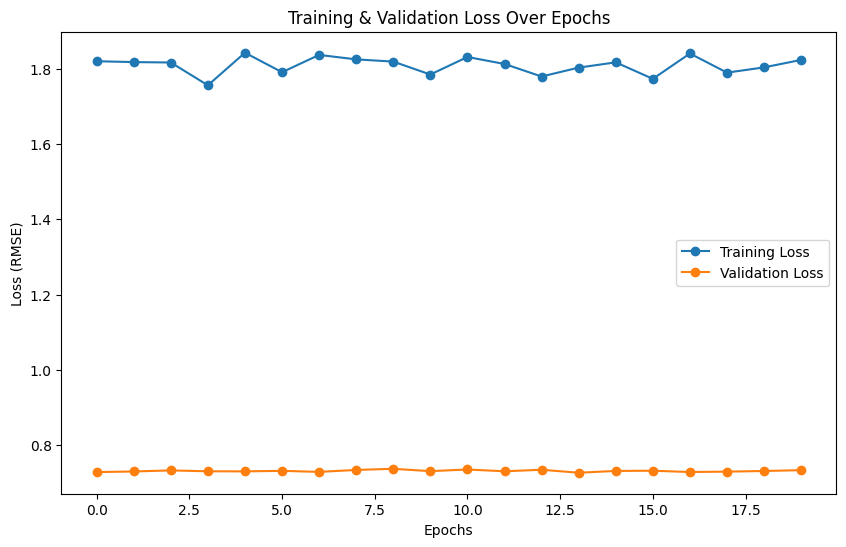

ASTGCN(
  (_blocklist): ModuleList(
    (0): ASTGCNBlock(
      (_temporal_attention): TemporalAttention()
      (_spatial_attention): SpatialAttention()
      (_chebconv_attention): ChebConvAttention(1, 64, K=3, normalization=None)
      (_time_convolution): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
      (_residual_convolution): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
      (_layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (1): ASTGCNBlock(
      (_temporal_attention): TemporalAttention()
      (_spatial_attention): SpatialAttention()
      (_chebconv_attention): ChebConvAttention(64, 64, K=3, normalization=None)
      (_time_convolution): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
      (_residual_convolution): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (_layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (_final_conv): Conv2d(1, 1, kernel_size=(1, 64), stride=

In [18]:
for epoch in range(20):
    print(f"Starting training for epoch {epoch + 1}...")
    model.train()
    step = 0
    loss_list = []

    for batch_data in train_loader:
        encoder_inputs, labels = batch_data
        encoder_inputs = encoder_inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        edge_index = edge_index.to(DEVICE)
        optimizer.zero_grad()

        # Forward pass
        y_hat = model(encoder_inputs, edge_index)

        # Compute loss
        loss = criterion(y_hat, labels)
        loss.backward()
        optimizer.step()

        step += 1
        loss_list.append(loss.item())

        if step % 10 == 0:
            print(f"Epoch {epoch + 1}, Step {step}, Training Loss: {loss.item():.4f}")

        if step % 30 == 0:
            print(f"Epoch {epoch + 1}, Step {step}, Performing validation...")
            vali_loss = compute_val_loss_mstgcn(model, val_loader, criterion, masked_flag, missing_value, epoch, edge_index)
            print(f"Epoch {epoch + 1}, Step {step}, Validation Loss: {vali_loss:.4f}")

            if vali_loss < min_vali_loss:
                wait = 0
                min_vali_loss = vali_loss
                best_epoch = epoch
                best_state_dict = copy.deepcopy(model.state_dict())
                print(f"Best epoch so far is {best_epoch + 1}, Validation Loss: {min_vali_loss:.4f}. Model saved.")
            else:
                wait += 1
                if wait >= early_stop:
                    print(f"Early stopping at epoch {epoch + 1}.")
                    model.load_state_dict(best_state_dict)
                    break  # Directly return, stopping training

            model.train()

    train_rmse = np.sqrt(np.mean(loss_list))
    train_losses.append(train_rmse)  # Traing loss for plot
    val_losses.append(vali_loss)     # Validation loss for plot

    print(f"Epoch {epoch + 1} Training RMSE: {train_rmse:.4f}")
    print(f"Epoch {epoch + 1} Validation Loss: {vali_loss:.4f}")

# 保存最佳模型
torch.save(best_state_dict, model_path)
print(f"Model saved to {model_path}")

# 收斂圖
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title('Training & Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (RMSE)')
plt.legend()
plt.show()

# 評估部分
model.eval()

In [ ]:
# 訓練過程
for epoch in range(20):
    print(f"開始訓練第 {epoch + 1} 個 epoch...")
    model.train()
    step = 0
    loss_list = []

    for batch_data in train_loader:
        encoder_inputs, labels = batch_data
        encoder_inputs = encoder_inputs.to(DEVICE)  # 確保 encoder_inputs 在 GPU 上
        labels = labels.to(DEVICE)  # 確保 labels 在 GPU 上
        edge_index = edge_index.to(DEVICE)  # 確保 edge_index 在 GPU 上
        optimizer.zero_grad()

        # 前向傳播：獲取模型預測
        y_hat = model(encoder_inputs, edge_index)

        # 計算損失
        loss = criterion(y_hat, labels)
        #print(f"Step {step + 1}, 計算損失 (loss): {loss.item():.4f}")  # 打印損失值
        loss.backward()
        optimizer.step()

        step += 1
        loss_list.append(loss.item())

        # 每 10 步打印一次當前訓練情況
        if step % 10 == 0:
            print(f"Epoch {epoch + 1}, Step {step}, 訓練損失: {loss.item():.4f}")

        # 每 30 步進行一次驗證
        if step % 30 == 0:
            print(f"Epoch {epoch + 1}, Step {step}, 正在進行驗證...")
            vali_loss = compute_val_loss_mstgcn(model, val_loader, criterion, masked_flag, missing_value, epoch, edge_index)
            print(f"Epoch {epoch + 1}, Step {step}, 驗證損失: {vali_loss:.4f}")

            if vali_loss < min_vali_loss:
                wait = 0
                min_vali_loss = vali_loss
                best_epoch = epoch
                best_state_dict = copy.deepcopy(model.state_dict())
                print(f"目前最佳的 epoch 是 {best_epoch + 1}，驗證損失: {min_vali_loss:.4f}，保存模型。")
            else:
                wait += 1
                if wait >= early_stop:
                    print(f"在 epoch {epoch + 1} 早停。")
                    model.load_state_dict(best_state_dict)
                    break

            model.train()

    # 輸出當前 epoch 的訓練和驗證結果
    train_rmse = np.sqrt(np.mean(loss_list))
    print(f"Epoch {epoch + 1} 訓練 RMSE: {train_rmse:.4f}")
    print(f"Epoch {epoch + 1} 驗證損失: {vali_loss:.4f}")

# 保存最佳模型
torch.save(best_state_dict, model_path)
print(f"模型已保存至 {model_path}")

# 評估部分
model.eval()

開始訓練第 1 個 epoch...
Epoch 1, Step 10, 訓練損失: 4.0310
Epoch 1, Step 20, 訓練損失: 3.1086
Epoch 1, Step 30, 訓練損失: 3.3412
Epoch 1, Step 30, 正在進行驗證...
Epoch 1, Step 30, 驗證損失: 0.7559
目前最佳的 epoch 是 1，驗證損失: 0.7559，保存模型。
Epoch 1, Step 40, 訓練損失: 3.2470
Epoch 1, Step 50, 訓練損失: 3.0194
Epoch 1, Step 60, 訓練損失: 3.2715
Epoch 1, Step 60, 正在進行驗證...
Epoch 1, Step 60, 驗證損失: 0.7500
目前最佳的 epoch 是 1，驗證損失: 0.7500，保存模型。
Epoch 1, Step 70, 訓練損失: 3.6542
Epoch 1, Step 80, 訓練損失: 3.2631
Epoch 1, Step 90, 訓練損失: 2.9790
Epoch 1, Step 90, 正在進行驗證...
Epoch 1, Step 90, 驗證損失: 0.7531
Epoch 1, Step 100, 訓練損失: 3.5443
Epoch 1, Step 110, 訓練損失: 2.3445
Epoch 1, Step 120, 訓練損失: 3.1259
Epoch 1, Step 120, 正在進行驗證...
Epoch 1, Step 120, 驗證損失: 0.7337
目前最佳的 epoch 是 1，驗證損失: 0.7337，保存模型。
Epoch 1, Step 130, 訓練損失: 3.2028
Epoch 1, Step 140, 訓練損失: 3.2653
Epoch 1, Step 150, 訓練損失: 3.0561
Epoch 1, Step 150, 正在進行驗證...
Epoch 1, Step 150, 驗證損失: 0.7217
目前最佳的 epoch 是 1，驗證損失: 0.7217，保存模型。
Epoch 1 訓練 RMSE: 1.8257
Epoch 1 驗證損失: 0.7217
開始訓練第 2 個 epoch...
Epoch 2

ASTGCN(
  (_blocklist): ModuleList(
    (0): ASTGCNBlock(
      (_temporal_attention): TemporalAttention()
      (_spatial_attention): SpatialAttention()
      (_chebconv_attention): ChebConvAttention(1, 64, K=3, normalization=None)
      (_time_convolution): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
      (_residual_convolution): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
      (_layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (1): ASTGCNBlock(
      (_temporal_attention): TemporalAttention()
      (_spatial_attention): SpatialAttention()
      (_chebconv_attention): ChebConvAttention(64, 64, K=3, normalization=None)
      (_time_convolution): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
      (_residual_convolution): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (_layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (_final_conv): Conv2d(1, 1, kernel_size=(1, 64), stride=

# ***Evaluate***

In [ ]:
# 測試部分
model.eval()  # 切換模型到評估模式
test_loss = 0

all_outputs = []  # 用於保存所有批次的預測結果
all_labels = []  # 用於保存所有批次的真實標籤

with torch.no_grad():  # 在測試過程中禁用梯度計算
    for batch_data in test_loader:
        encoder_inputs, labels = batch_data
        encoder_inputs = encoder_inputs.to(DEVICE)  # 將數據移動到 GPU
        labels = labels.to(DEVICE)
        edge_index = edge_index.to(DEVICE)

        # 模型推斷
        y_hat = model(encoder_inputs, edge_index)

        # 計算損失
        if masked_flag:
            mask = (labels != missing_value).float()
            loss = (criterion(y_hat, labels) * mask).mean()
        else:
            loss = criterion(y_hat, labels)

        test_loss += loss.item()

        # 保存當前批次的預測結果和真實標籤
        all_outputs.append(y_hat.cpu())
        all_labels.append(labels.cpu())

# 計算平均測試損失
test_loss /= len(test_loader)
print(f"測試損失: {test_loss:.4f}")

# 將所有批次的結果拼接成一個大的張量
all_outputs = torch.cat(all_outputs, dim=0)
all_labels = torch.cat(all_labels, dim=0)

# 可視化部分
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# 取出一部分樣本進行可視化比較
sample_output = all_outputs[:50]  # 取前 50 個樣本的預測
sample_labels = all_labels[:50]  # 取前 50 個樣本的真實值

# 檢查形狀
print(f"Sample output shape: {sample_output.shape}, Sample labels shape: {sample_labels.shape}")

# 設置圖形的大小和 DPI
figure(figsize=(30, 4), dpi=80)

# 可視化50個序列的預測值與真實值
for i in range(50):
    new_i = i * 12
    plt.plot(range(0+new_i, 12+new_i), sample_output[i].detach().numpy(), color='red', label='Prediction' if i == 0 else "")
    plt.plot(range(0+new_i, 12+new_i), sample_labels[i].numpy(), color='blue', label='Truth' if i == 0 else "")

# 添加圖例以區分預測值和真實值
plt.legend()

# 顯示圖形
plt.show()

Test MSE: 4.1212
